In [1]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt 
from generate_sample import generate_sample as gs

from tensorflow.contrib import rnn

% matplotlib inline
plt.style.use('ggplot')

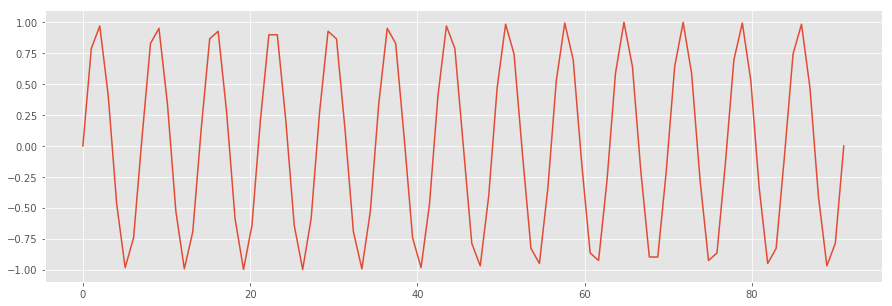

In [2]:
amplitude = 1
peroid = 7
frequency = np.pi * 2 / peroid
max_range = peroid * 13
sample_size = max_range

time_steps = np.linspace(0, max_range, sample_size)
outputs = amplitude * np.sin(frequency * time_steps)


plt.plot(time_steps, outputs)
fig = plt.gcf()
fig.set_size_inches(15, 5)

# Parameters

In [3]:
learning_rate = 1e-4
n_epoch = 10
epoch_size = 100
n_iter = n_epoch * epoch_size
batch_size = 50


n_input = 1
n_steps = 10
n_hidden = 128
n_outputs = 10

In [4]:
# More data Prep
total = sample_size-(n_outputs+n_steps*n_input)
past = np.empty((total, n_steps*n_input))
future = np.empty((total, n_outputs))



for i in range(total):
    past[i,:] =outputs[i:i+n_steps*n_input]
    future[i, :] = outputs[i+n_steps*n_input : i+n_steps*n_input + n_outputs]

train_ratio = 0.8
train_size = int(len(past) * train_ratio)

train_past = past[:train_size]
train_past = train_past.reshape((train_size, n_steps, n_input))
train_future = future[:train_size]

test_past = past[train_size:]
test_past = test_past.reshape((len(test_past), n_steps, n_input))
test_future = future[train_size:]

In [5]:
def my_rnn(x, W, b):
    x = tf.transpose(x, [1, 0, 2])
    x = tf.reshape(x, [-1, n_input])
    x = tf.split(x, n_steps, axis=0)
    
    lstm_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
    return tf.nn.bias_add(tf.matmul(outputs[-1], W), b)

In [8]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_outputs])

W = tf.Variable(tf.truncated_normal([n_hidden, n_outputs]))
b = tf.Variable(tf.truncated_normal([n_outputs]))

h = my_rnn(x, W, b)

individual_losses = tf.reduce_sum(tf.squared_difference(h,y), reduction_indices=1)
loss = tf.reduce_mean(individual_losses)
optimiser = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [9]:
#%%time 
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for iter in range(n_iter+1):
    # No mini Batch yet
    optimiser.run(feed_dict={x:train_past, y:train_future})
    
    if iter% epoch_size ==0:
        print('Epoch: {}' .format(int(iter/epoch_size)))
        print('Loss: {}' .format(loss.eval(feed_dict={x:train_past, y:train_future})))
    

Epoch: 0
Loss: 11.650124549865723
Epoch: 1
Loss: 3.297325849533081
Epoch: 2
Loss: 1.0903853178024292
Epoch: 3
Loss: 0.2390386313199997
Epoch: 4
Loss: 0.010156701318919659
Epoch: 5
Loss: 0.0010233598295599222
Epoch: 6
Loss: 0.0005919861723668873
Epoch: 7
Loss: 0.00039904771256260574
Epoch: 8
Loss: 0.00026752418489195406
Epoch: 9
Loss: 0.00017910775204654783
Epoch: 10
Loss: 0.00012073841935489327


In [10]:
print('Test loss: {}'
     .format(loss.eval(feed_dict={x:test_past, y:test_future})))

Test loss: 0.00012091168173355982


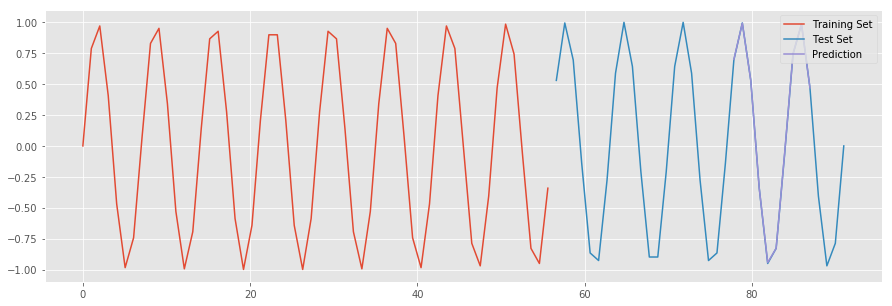

In [26]:
plt.plot(time_steps[:train_size], outputs[:train_size], label='Training Set')
plt.plot(time_steps[train_size:], outputs[train_size:], label='Test Set')

fig = plt.gcf()
fig.set_size_inches(15, 5)

ans = h.eval(feed_dict={x:past.reshape((len(past), n_steps, n_input))})
index = 67
plt.plot(time_steps[index+n_outputs:index + n_outputs*2], ans[index,:], label='Prediction')

plt.legend(loc=1)
#plt.plot(time_steps[train_size:train_size+n_outputs], ans[0,:], label='Test?')
#plt.plot(time_steps[train_size:train_size+n_outputs], outputs[train_size:train_size+n_outputs], label='test')